# Машинное обучение, ФКН ВШЭ

# Практическое задание 11. Поиск ближайших соседей

## Общая информация

Дата выдачи: 6.06.2020

Жёсткий дедлайн: 12.06.2020 07:00 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Задание является дополнительным, то есть само по себе не учитывается в накопленной оценке. Все полученные за задание баллы являются бонусными, то есть их можно прибавить к оценке за любое теоретическое или практическое домашнее задание из курса. Максимальная оценка за работу — 13 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи

Задания сдаются через систему anytask. Посылка должна содержать:

* Ноутбук homework-practice-11-knn-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке.

---

# Часть 0. Введение в Cython

Как вы уже могли понять из предыдущих заданий курса и практического опыта, язык Python сам по себе не отличается высокой производительностью. Причин этому много (в частности, Global Interpreter Lock, динамическая типизация и накладные расходы интерпретатора), и обойти их зачастую получается посредством использования функций из компилируемых языков (например, C или C++). 

Благодаря NumPy и другим библиотекам, которые имеют Python-интерфейс к таким функциям, часто получается перенести вычислительно трудоёмкие операции на другой язык программирования, получая сильный прирост скорости кода при минимальном вреде для читаемости. Избегать циклов средствами Python по большому числу элементов рекомендуется только потому что пресловутая векторизация чаще всего заключается в таких же циклах, но на более быстрых языках (хотя иногда возможно дополнительное ускорение за счёт SIMD/тредов/BLAS и аналогов). 

Однако иногда в вычислительно трудоёмком коде может потребоваться использование структур данных, отличных от многомерных массивов (например, очередь или стек), либо использование кода на NumPy становится сложным из-за трудоёмкой и неинтуитивной векторизации операций. К тому же, может случиться, что ни одна из встроенных функций NumPy не подходит под решаемую задачу, но требования к производительности всё ещё высоки.

В таких ситуациях имеет смысл использовать [Cython](https://cython.readthedocs.io/en/latest/index.html) — надмножество языка Python, поддерживающее указание C-подобных типов для переменных в коде, использование функций напрямую из C и компиляцию Python-кода. У него достаточно подробная [документация](https://cython.readthedocs.io/en/latest/src/tutorial/index.html), но мы разберём пару наглядных примеров, демонстрирующих, как простыми методами заметно ускорить выполнение Python-программ. Сначала загрузим это расширение, чтобы компилировать напрямую в Jupyter:

In [1]:
%load_ext cython

Допустим, нам зачем-то захотелось написать с нуля бинарный поиск. Его реализация на обычном Python иожет выглядеть так (честно взято из https://github.com/python/cpython/blob/master/Lib/bisect.py#L50):

In [2]:
def binarySearch(arr, x):
    lo = 0
    hi = len(arr)

    while lo < hi:
        mid = (lo+hi)//2
        
        if arr[mid] < x:
            lo = mid+1
        else:
            hi = mid
    return lo

Создадим тестовый массив и протестируем результаты данной реализации, встроенного в модуль `bisect` бинарного поиска и `np.searchsorted`, а также сравним время работы всех функций.

In [3]:
import numpy as np
np.random.seed(0xDEADF00D)

arr = np.random.randint(0, 500, size=10000, dtype=np.int32)
arr.sort()

In [4]:
import bisect

binarySearch(arr,4) == np.searchsorted(arr, 4) == bisect.bisect_left(arr,4)

True

In [5]:
%timeit binarySearch(arr,4)

27.8 µs ± 688 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [6]:
%timeit bisect.bisect_left(arr,4)

24.8 µs ± 498 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
%timeit np.searchsorted(arr, 4)

7.55 µs ± 66.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Заметим, что наш код работает медленнее реализации из `bisect`, а функция `searchsorted` из NumPy оказалась быстрее всего. Попробуем просто скомпилировать функцию в Cython и посмотреть на результаты. Это можно сделать посредством [jupyter magic](https://cython.readthedocs.io/en/latest/src/quickstart/build.html#using-the-jupyter-notebook):

In [8]:
%%cython -a
# cython: language_level=3

def binarySearch_v1(arr, x):
    lo = 0
    hi = len(arr)

    while lo < hi:
        mid = (lo+hi)//2
        
        if arr[mid] < x:
            lo = mid+1
        else:
            hi = mid
    return lo

In [9]:
%timeit binarySearch_v1(arr,4)

26.4 µs ± 265 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Опция `-a` позволит увидеть, как много в результирующем коде взаимодействия с Python (чем интенсивнее жёлтый цвет, тем больше). С помощью такой аннотации можно понять, какие сегменты программы и по какой причине не генерируют оптимизированный код.

Как мы видим, код на Python — это валидный код для Cython, однако компиляция конкретно в этом случае почти ничего нам не дала. Если посмотреть на инструкции, которые генерирует компилятор, можно увидеть большое количество взаимодействий с garbage collector и вызовов неспецифичных методов объектов. Давайте типизируем все переменные в функции и посмотрим на результат. Подробнее можно посмотреть [здесь](https://cython.readthedocs.io/en/latest/src/quickstart/cythonize.html) (там есть ещё пример с ускорением кода) и [про NumPy здесь](https://cython.readthedocs.io/en/latest/src/tutorial/numpy.html) и [здесь](https://cython.readthedocs.io/en/latest/src/userguide/memoryviews.html). Если вы не используете функции NumPy напрямую, то лучше применять memoryview (как в примере ниже) из-за быстрой индексации и отсутствия оверхеда от взаимодействия через Python API; если вам нужны оптимизированные примитивы линейной алгебры наподобие умножения матриц или скалярного произведения, они есть в [SciPy](https://docs.scipy.org/doc/scipy/reference/linalg.cython_blas.html) напрямую для Cython.

In [10]:
%%cython -a
# cython: language_level=3

cpdef Py_ssize_t binarySearch_v2(int[::1] arr,int x):
    cdef:
        Py_ssize_t lo = 0
        Py_ssize_t hi = len(arr)
        Py_ssize_t mid

    while lo < hi:
        mid = (lo+hi)//2
        
        if arr[mid] < x:
            lo = mid+1
        else:
            hi = mid
    return lo

In [11]:
%timeit binarySearch_v2(arr,4)

654 ns ± 1.42 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Мы получили ускорение почти в 40 раз за счёт простого добавления типов переменных. Можно добиться ещё ряда оптимизаций даже в случае бинарного поиска: во-первых, при индексировании отрицательным числом компилятору требуется переходить в другую ветку кода и прибавлять к индексу длину массива, что может быть лишней операцией в нашем случае. Для отключения таких проверок (и, соответственно, отрицательных индексов) есть специальная [директива компилятора](https://cython.readthedocs.io/en/latest/src/userguide/source_files_and_compilation.html#compiler-directives) `wraparound=False`. Также мы отключим проверки на `None`, проверки на выход за границы массива и проверки на деление на 0:

In [12]:
%%cython -a
# cython: language_level=3

cimport cython

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
@cython.nonecheck(False)
cpdef Py_ssize_t binarySearch_v3(int[::1] arr,int x):
    cdef:
        Py_ssize_t lo = 0
        Py_ssize_t hi = len(arr)
        Py_ssize_t mid

    while lo < hi:
        mid = (lo+hi)//2
        
        if arr[mid] < x:
            lo = mid+1
        else:
            hi = mid
    return lo

In [13]:
%timeit binarySearch_v3(arr,4)

630 ns ± 0.0393 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Как видим, это позволяет добиться небольшого прироста производительности даже в случае очень простых алгоритмов. Также директивы компилятора можно задавать на уровне модуля (или ячейки в Jupyter), чтобы не декорировать каждую функцию отдельно:

In [14]:
%%cython -a
# cython: language_level=3
# cython: infer_types=True
# cython: boundscheck=False
# cython: wraparound=False
# cython: nonecheck=False
# cython: cdivision=True

cpdef Py_ssize_t binarySearch_v3(int[::1] arr,int x):
    cdef:
        Py_ssize_t lo = 0
        Py_ssize_t hi = len(arr)
        Py_ssize_t mid

    while lo < hi:
        mid = (lo+hi)//2
        
        if arr[mid] < x:
            lo = mid+1
        else:
            hi = mid
    return lo

У Cython есть и другое применение: можно забыть все, чему нас учили, и писать невекторизованный код, который работает быстрее векторизованного. Разумеется, это не получится всегда, но в случае, когда несколько операций над одними и теми же данными можно скомбинировать, есть возможность получить прирост в скорости. Пример такого приведён ниже:

In [15]:
import numpy as np

def process_arr(x):
    return np.sin(x)*5*np.square(x)-np.cumsum(x)/len(x)

Пример ниже также показывает, что в Cython можно писать шаблонные функции с помощью [fused types](https://cython.readthedocs.io/en/latest/src/userguide/fusedtypes.html) и импортировать функции напрямую из C или даже C++ (об этом чуть позже):

In [16]:
%%cython
from libc.math cimport pow, sin
# cython: language_level=3
# cython: infer_types=True
# cython: boundscheck=False
# cython: wraparound=False
# cython: nonecheck=False
# cython: cdivision=True
import numpy as np

ctypedef fused any_float:
    float
    double

cpdef any_float[::1] process_arr_v1(any_float[::1] x):
    cdef:
        any_float cumsum = 0
        any_float[::1] buf = np.empty_like(x)
        Py_ssize_t i, size = x.shape[0]
    for i in range(size):
        cumsum += x[i]
        buf[i] = sin(x[i])*5*pow(x[i], 2)-cumsum/size
    return buf

In [17]:
arr=np.random.randn(100)

In [18]:
%timeit process_arr(arr)

11.8 µs ± 29.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [19]:
%timeit process_arr_v1(arr)

6.86 µs ± 17.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [20]:
arr=np.random.randn(100000)

In [21]:
%timeit process_arr(arr)

3.83 ms ± 286 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%timeit process_arr_v1(arr)

2.56 ms ± 832 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
assert np.allclose(process_arr(arr), process_arr_v1(arr))

Как видим, невекторизованный код минимальными усилиями получилось ускорить до векторизованного. В завершение покажем, как пользоваться конструкциями из языка [C++](https://cython.readthedocs.io/en/latest/src/userguide/wrapping_CPlusPlus.html). Вообще говоря, в руководстве по ссылке демонстрируется возможность написания интерфейса для произвольного C++-класса, но мы ограничимся использованием [портированных](https://github.com/cython/cython/tree/master/Cython/Includes/libcpp) в Cython классов и функций из стандартной библиотеки. 

Чтобы компилировать Cython с поддержкой C++, нужно передать флаг `--cplus` и при сборке в командной строке, и при использовании Jupyter. Также для определения нетривиальных контейнеров нужно пользоваться командой `ctypedef`. Пример также показывает, как можно определять в Cython [классы](https://cython.readthedocs.io/en/latest/src/tutorial/cdef_classes.html), которые могут пользоваться C++-объектами.

In [24]:
%%cython --cplus -c=-std=c++14
# cython: language_level=3
# cython: infer_types=True
# cython: boundscheck=False
# cython: wraparound=False
# cython: nonecheck=False
# cython: cdivision=True

from libcpp.unordered_map cimport unordered_map
from libcpp.stack cimport stack
from libcpp.queue cimport queue

from cython.operator import dereference

ctypedef stack[int] int_stack
ctypedef unordered_map[int, int_stack] stack_map

cdef:
    unordered_map[int, int_stack].iterator it # we can even use iterators

cdef class MapInterface:
    cdef stack_map smap # attributes need to be declared outside of init
    
    def __init__(self):
        cdef:
            int i=0
            queue[int] cur_queue
            int_stack cur_stack
            Py_ssize_t j, k
        self.smap = stack_map()
        
        for j in range(10):
            cur_stack = int_stack()
            cur_queue = queue[int]()
            for k in range(j+1):
                cur_stack.push(k)
                cur_queue.push(k)
            print(cur_stack.top(),cur_queue.front())
            self.smap[<int>j] = cur_stack # type casting is supported as well

        
    cpdef int get_top_by_key(self, int key):
        cdef unordered_map[int, int_stack].iterator it = self.smap.find(key)
        if it == self.smap.end():
            raise KeyError(key) # exceptions are thrown the same way
        cdef int_stack found_stack = dereference(it).second
        return found_stack.top()
    
cdef MapInterface map_interface = MapInterface()
    
it = map_interface.smap.find(10)
print(it == map_interface.smap.end())
# you can cast the pointer, cast it back and dereference with square bracket notation
print(dereference(<int*>(<void*>&map_interface.smap[5].top())))
print(map_interface.get_top_by_key(5))
print(map_interface.get_top_by_key(20))

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
True
5
5


KeyError: 20

Exception ignored in: '_cython_magic_d9b0fec9e9d67eace73935ed3c2d8086.MapInterface.get_top_by_key'
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
KeyError: 20


0


# Часть 1. Locality-Sensitive Hashing

В этом задании мы будем работать с датасетом [FashionMnist](https://github.com/zalandoresearch/fashion-mnist) изображений предметов одежды и обуви. В файле уже находится массив со 100 найденными соседями каждого тестового объекта по евклидовой метрике, однако мы для начала (чтобы реализовать метод случайных проекций) попробуем найти 100 ближайших соседей для каждого объекта по косинусной близости.

Ниже вы можете увидеть, как загружается этот датасет, и посмотреть на примеры нескольких изображений из обучающей выборки.

In [25]:
!wget -nc -q http://ann-benchmarks.com/fashion-mnist-784-euclidean.hdf5

In [26]:
import h5py

with h5py.File('fashion-mnist-784-euclidean.hdf5', 'r') as f:
    train = f['train'][()]
    test = f['test'][()]
    true_neighbors_eucl = f['neighbors'][()]

print(train.shape)
print(test.shape)
print(true_neighbors_eucl.shape)

(60000, 784)
(10000, 784)
(10000, 100)


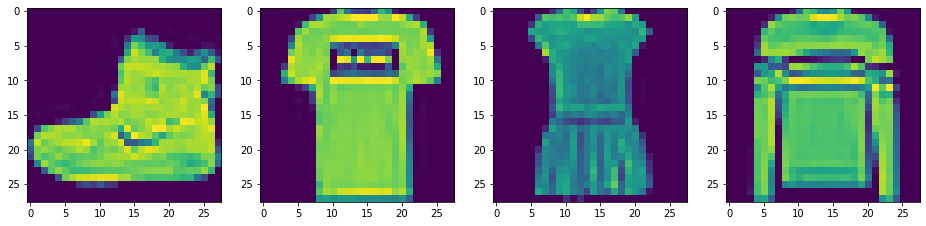

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 4))
plt.subplot(141)
plt.imshow(train[0].reshape(28, 28))
plt.subplot(142)
plt.imshow(train[1].reshape(28, 28))
plt.subplot(143)
plt.imshow(train[3].reshape(28, 28))
plt.subplot(144)
plt.imshow(train[5].reshape(28, 28))

В библиотеке `scikit-learn` есть [модуль](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors) с алгоритмами поиска ближайших соседей, помогающий решать задачи классификации и регрессии. В этом задании, однако, нас будет интересовать не классификация, а качество и скорость решения непосредственно задачи поиска. Определим для этого две метрики:
* Recall: доля «настоящих соседей», которых нашёл алгоритм поиска. Пример: если вам необходимо найти 100 ближайших соседей, и из 100 возвращённых алгоритмом объектов 93 действительно находятся в множестве ближайших, то полнота равна 0.93.
* Queries per second (QPS), также requests per second (RPS): число запросов, на которое алгоритм успевает ответить за одну секунду. Часто эту характеристику вычисляют как $num\_queries/total\_time$, где $num\_queries$ — общее число запросов, а $total\_time$ — суммарное время их выполнения; однако, так как некоторые реализации в задании умеют группировать запросы и выполнять несколько параллельно, мы будем осуществлять их по отдельности и усреднять величину $1/request\_time$.

Хотя в классе `NearestNeighbors` нет методов приближённого поиска ближайших соседей, мы воспользуемся им, чтобы найти 100 ближайших объектов по косинусной близости, сформировав таким образом правильные ответы для приближённых методов. Алгоритмы `kd_tree` и `ball_tree` в этом классе не поддерживают `metric=cosine`, поэтому распараллелим полный перебор: 

In [ ]:
from sklearn.neighbors import NearestNeighbors

sklearn_index = NearestNeighbors(n_neighbors=100,
                                 algorithm='brute',
                                 metric='cosine',
                                 n_jobs=-1)
sklearn_index.fit(train)

true_neighbors_cosine = sklearn_index.kneighbors(test,
                                                 n_neighbors=100,
                                                 return_distance=False)

В ячейке ниже определяются гиперпараметры алгоритма LSH: размерность хэша (так как для каждой гиперплоскости мы храним только знак скалярного произведения, каждую координату можно представить одним битом) и число хэш-таблиц, а также создаётся массив гиперплоскостей для каждого бита в хэше и каждой таблицы.

In [ ]:
np.random.seed(0xDEADF00D)

NUM_TABLES = 20
NUM_BITS = 8

random_hyperplanes = np.random.randn(NUM_TABLES, NUM_BITS, train.shape[1]).astype(np.float32)

**Задание 1. (3 балла)**

Реализуйте на Cython все методы класса `LSHIndex`, а затем постройте индекс по датасету FashionMNIST и подсчитайте recall вашего решения. Чтобы для удобства вместо косинусной близости считать скалярное произведение, и обучающую, и тестовую части датасета можно нормировать заранее.

Здесь и в последующих заданиях на использование Cython при оценивании будут применяться следующие штрафы для неэффективного кода (компилируйте свой класс с `cython -a` для удобства проверяющих):
* Использование функций из numpy (-10% от максимального балла). Вы можете отказаться от numpy-массивов как аргументов функций в предложенном шаблоне и перейти на использование memoryviews, если это окажется удобнее.
* Взаимодействие с Python-объектами (коллекции, классы) в критических частях циклов (-20% от максимального балла)
* Не указаны типы используемых переменных либо не продемонстрировано, что типизация не ускоряет код (до -20% от максимального балла)

In [ ]:
%%cython -a --cplus -c=-std=c++14
# cython: embedsignature=True
# cython: initializedcheck=False
# cython: boundscheck=False
# cython: wraparound=False
# cython: nonecheck=False
# cython: cdivision=True

import numpy as np
cimport numpy as cnp
cimport scipy.linalg.cython_blas as blas
cimport cython

ctypedef vector[Py_ssize_t] s_vec

cdef cnp.ndarray[cnp.uint32_t] compute_hashes(cnp.ndarray[cnp.float32_t, ndim=3] matrices,
                                                    cnp.ndarray[cnp.float32_t] query):
    """
    Compute hash values for each hash table and a given vector.
    Args:
        matrices: np.array of shape (NUM_TABLES, NUM_BITS, dim), last axis represents
            random hyperplanes for each hash bit of each table
        query: vector to be hashed
    Returns:
        hashes: np.array of shape (NUM_TABLES, ), contains hash values for each table as unsigned integers
    """
    pass

cdef class LSHIndex:
    def __init__(self, cnp.ndarray[cnp.float32_t, ndim=2] vectors,
                  cnp.ndarray[cnp.float32_t, ndim=3] projection_matrices):
        """
        Build the index and store vectors for efficient neighbors search.
        Args:
            vectors: Training data, np.array (num_vectors, dim). Each k-NN query looks for neighbors in this set
            projection_matrices: np.array of shape (NUM_TABLES, NUM_BITS, dim), last axis represents
                random hyperplanes for each hash bit of each table
        """
        pass
        
    cpdef query(self, cnp.ndarray[cnp.float32_t] query, unsigned k_neighbors):
        """
        A helper function to perform a k-NN query. Computes hashes and allocates memory outside the cdef function
            to avoid numpy calls in search_neighbors.
        Args:
            query: a normalized query vector the neighbors of which we need to find
            k_neighbors: the number of neighbors to return
        Returns:
            neighbors: a list (or a C++ vector, they're interchangeable) of indices in the dataset
                used to build the index. Vectors at these positions represent approximate k nearest neighbors of
                the query, indices do not need to be sorted by any property
        """
        cdef unsigned[:] hashes = compute_hashes(np.asarray(self.matrices), query)
        return self._search_neighbors(query, k_neighbors, hashes)
    
    cdef s_vec _search_neighbors(self, float[::1] query, unsigned k_neighbors, unsigned[:] hashes) nogil:
        """
        All the fun happens here. Given a sample, its hashes and the number  of neighbors, locate nearest neighbors
            wrt cosine similarity using the hash tables built during index construction.
        Args:
            query: a normalized query vector the neighbors of which we need to find
            k_neighbors: the number of neighbors to return
            hashes: an array containing hash values of query for each hash table
        Returns:
            neighbors: a list (or a C++ vector, they're interchangeable) of indices in the dataset
                used to build the index. Vectors at these positions represent approximate k nearest neighbors of
                the query, indices do not need to be sorted by any property
        """
        pass

In [ ]:
# ପ(⚈᷉ʙ⚈᷉)੭̸୫炎炎炎炎炎炎炎

Ниже приведена реализация функции для подсчёта всех интересующих нас метрик.

In [ ]:
from tqdm.auto import tqdm
from time import perf_counter


def compute_recall_qps(query_func: callable, testset: np.ndarray, true_neighbors: np.ndarray, **kwargs):
    """
    Given a function that returns a list of nearest neighbors, estimate its recall and speed.
    Args:
        query_func: function with signature (query, k_neighbors, **kwargs).
            Returns a list of k_neighbors approximate nearest neighbors for a query
        testset: array with shape (num_objects, dim). Contains query vectors for recall evaluation
        true_neighbors: array of indices with shape (num_objects, num_neighbors). Contains ground truth data for
            recall evaluation. k_neighbors from query_func is inferred from its shape
        **kwargs: passed to query_func
    Returns:
        avg_recall: average recall of query_func over the test set
        qps: number of queries per second handled by query_func 
    """
    recalls = []
    query_times = []

    for sample, neighbors_for_sample in zip(testset, tqdm(true_neighbors)):
        start = perf_counter()
        approx_neighbors = query_func(
            sample, k_neighbors=neighbors_for_sample.shape[0], **kwargs)
        query_times.append(1 / (perf_counter() - start))
        set_true = set(neighbors_for_sample.tolist())
        hits = sum(1 for neighbor in approx_neighbors if neighbor in set_true)
        recalls.append(hits / len(set_true))

    return np.mean(recalls), np.mean(query_times)

In [ ]:
# recall, qps = ...
print(recall, qps)
assert recall>=0.98

Визуализируйте пример работы алгоритма: найдите 5 ближайших соседей для нескольких объектов тестовой выборки и покажите, каким изображениям они соответствуют (вместе с самим запросом).

In [ ]:
#╰( ´・ω・)つ──☆✿✿✿✿✿✿

**Задание 2. (1 балл)**

Исследуйте и покажите на графиках зависимость recall и QPS от размера хэша и числа хэш-таблиц. Сравните вашу реализацию с классом sklearn.neighbors.NearestNeighbors: так как для косинусной близости в этом классе поддерживается только algorithm='brute', вы получите время работы точного поиска ближайших соседей. Для честности сравнения укажите в конструкторе метода n_jobs равным 1 и при замерах времени проводите поиск соседей для каждого объекта отдельно.

Отметьте соответствующую ему точку на графике recall-QPS, а затем с помощью перебора гиперпараметров LSH постройте кривую в этих координатах для вашей реализации (нужно протестировать хотя бы 5 различных комбинаций размера хэша и числа таблиц). При построении можете вдохновляться графиками с сайта [ann-benchmarks](http://ann-benchmarks.com/):

![](http://ann-benchmarks.com/fashion-mnist-784-euclidean_100_euclidean.png)

In [ ]:
# (@・∀・)✎

**Задание 3. (2 балла)**

Как вы знаете из лекций, семейство хэш-функций, порождаемое случайными гиперплоскостями, подходит только для косинусного расстояния. Воспользуйтесь подходом, предложенным в статье с RecSys 2014 [«Speeding Up the Xbox Recommender System Using a Euclidean Transformation for Inner-Product Spaces»](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/XboxInnerProduct.pdf), и сведите задачу поиска ближайших соседей по евклидовой метрике к задаче поиска ближайших соседей по косинусной близости (важно заметить, что нормы векторов могут быть произвольными и поэтому метрики сами по себе не эквивалентны). 

Преобразуйте данные и проведите аналогичные эксперименты с реализацией из scikit-learn для metric='euclidean' и algorithm='ball_tree'.

In [ ]:
# (。・ω・)＝《《≠≠≠≠≠≠≠≠〇

# Часть 2. Navigable Small World

**Задание 4. (3 балла)**

Ниже расположен шаблон класса `NSWIndex`, который реализует алгоритм [Navigable Small World](https://publications.hse.ru/mirror/pubs/share/folder/x5p6h7thif/direct/128296059). Реализуйте все его методы, а затем постройте индекс по датасету FashionMNIST и подсчитайте recall вашего решения.

In [ ]:
%%cython --cplus -c=-std=c++14
# cython: language_level=3
# cython: embedsignature=True
# cython: infer_types=True
# cython: boundscheck=False
# cython: wraparound=False
# cython: nonecheck=False
# cython: cdivision=True

ctypedef vector[Py_ssize_t] s_vec


cdef class NSWIndex:
    def __init__(self, float[:,::1] vectors, unsigned num_neighbors, unsigned num_construction_runs):
        """
        Build the index and store vectors for efficient neighbors search.
        Args:
            vectors: Training data, np.array (num_vectors, dim). Each k-NN query looks for neighbors in this set
            num_neighbors: how many neighbors to look for during sequential insertion
            num_construction_runs: number of search attempts in k-NN search during construction
        """
        pass

    cpdef s_vec query(self, float[::1] query, unsigned k_neighbors, unsigned num_search_runs):
        """
        A helper function to perform a k-NN query. Used to ensure that _knn_search can be called with GIL lifted.
        Args:
            query: a normalized query vector the neighbors of which we need to find
            k_neighbors: the number of neighbors to return
            num_search_runs: number of search attempts (parameter m in the NSW paper)
        Returns:
            neighbors: a list of indices in the dataset used to build the index. Vectors at these positions
            represent approximate k nearest neighbors of the query, indices do not need to be sorted
        """
        return self._knn_search(sample,k_neighbors,num_search_runs)
                
    cdef s_vec _knn_search(self, float[::1] query, unsigned k_neighbors, unsigned num_search_runs) nogil:
        """
        Run the NSW search algorithm in a constructed graph.
        Args:
            query: a normalized query vector the neighbors of which we need to find
            k_neighbors: the number of neighbors to return
            num_search_runs: number of search attempts (parameter m in the NSW paper)
        Returns:
            neighbors: a list of indices in the dataset used to build the index. Vectors at these positions
            represent approximate k nearest neighbors of the query, indices do not need to be sorted
        """
        pass

In [ ]:
nsw_index = NSWIndex(train_normalized, 5, 5)
recall, qps = compute_recall_qps(nsw_index.query, test_normalized, true_neighbors_cosine, num_search_runs=2)
print(recall, qps)
assert recall >= 0.98

**Задание 5. (1 балл)**

Исследуйте и покажите на графиках зависимость recall и QPS от размера хэша и числа хэш-таблиц. Сравните вашу реализацию с классом sklearn.neighbors.NearestNeighbors и LSHIndex, построив recall-QPS-кривые в зависимости от параметров `num_construction_runs` и `num_search_runs`.

In [ ]:
# ੭•̀ω•́)੭̸*✩⁺˚

**Задание 6. (1 балл)**

Воспользуйтесь библиотекой nmslib, в которой есть эффективная реализация алгоритма HNSW. Постройте индекс для датасета и постройте аналогичную прошлым заданиям кривую recall-qps, варьируя параметры `efConstruction`, `M` и `efSearch`.

In [ ]:
import nmslib
# -_-)_／☆･ ･ ･ ‥……━━●~*

**Задание 7. (2 баллов)**

Реализуйте параллельную версию поиска ближайших соседей методом NSW, пользуясь [cython.parallel](https://cython.readthedocs.io/en/latest/src/userguide/parallelism.html). Для этого можно заметить, что и отдельные запуски поиска для одного объекта, и поиск соседей для разных объектов можно реализовать как независимые процедуры.

Оцените качество и скорость работы вашего метода на датасете [glove-100-angular](http://ann-benchmarks.com/glove-100-angular.hdf5), в обучающей выборке которого содержится 1183514 объектов, сравнив его с реализацией HNSW библиотеки nmslib. Для сравнения, как и обычно, используйте recall-QPS-кривую.

In [ ]:
!wget -nc http://ann-benchmarks.com/glove-100-angular.hdf5

In [ ]:
with h5py.File('glove-100-angular.hdf5','r') as f:
    print(f.keys())
    glove_train=f['train'][()]
    glove_test=f['test'][()]
    glove_neighbors=f['neighbors'][()]

In [ ]:
# (❀∩´◔‿ゝ◔`⑅)⊃―☆　*’“*:.｡. .｡.:*･゜ﾟ･♡♪+*.